# 🌌 Master Notebook – Pipeline Spectroscopie DR5

## Objectif du pipeline

- Ce notebook télécharge, prépare et journalise des spectres .fits.gz de LAMOST DR5 pour entraîner un modèle de classification.
- Le DatasetBuilder garantit qu'aucun spectre ne sera jamais réutilisé en s'appuyant sur un log de fichiers déjà traités.
- Ce pipeline permet d’ajouter progressivement des spectres au jeu d’entraînement, en assurant qu’aucun spectre ne soit traité deux fois. Chaque exécution sélectionne un nouveau lot, l’entraîne, puis marque les spectres comme utilisés.


#

## Étape 0 : SETUP & IMPORTS

In [1]:
import os
import sys
import pandas as pd
from IPython.display import display, Markdown
from datetime import datetime, timezone
import json
import hashlib
import subprocess

# --- Initialisation de l'environnement via notre outil ---
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils import setup_project_env
paths = setup_project_env()

# --- On définit les variables de chemin globales pour tout le notebook ---
# Cela évite de les redéfinir dans chaque cellule
RAW_DATA_DIR = paths["RAW_DATA_DIR"]
CATALOG_DIR = paths["CATALOG_DIR"]
PROCESSED_DIR = paths["PROCESSED_DIR"]
MODELS_DIR = paths["MODELS_DIR"]
REPORTS_DIR = paths["REPORTS_DIR"]

# --- Imports des outils spécifiques au pipeline ---
from tools.dataset_builder import DatasetBuilder
from pipeline.processing import ProcessingPipeline
from pipeline.classifier import SpectralClassifier
# On importe la fonction pour générer le catalogue local si elle est dans un module
from tools.generate_catalog_from_fits import generate_catalog_from_fits 

# --- Initialisation des outils ---
builder = DatasetBuilder(raw_data_dir=RAW_DATA_DIR, catalog_dir=CATALOG_DIR)

print("\nSetup terminé. Tu es prêt à lancer ton pipeline.")

[INFO] Racine du projet détectée : c:\Users\alexb\Documents\Google_Cloud\alex_labs_google_sprint\astro_spectro_git
[INFO] Dossier 'src' ajouté au sys.path.

Setup terminé. Tu es prêt à lancer ton pipeline.


#

## 1) Téléchargement des spectres
Utilisation du script ``dr5_downloader.py`` encapsulé en fonction.

Cette étape est désormais externalisée dans [01_download_spectra.ipynb](./01_download_spectra.ipynb) pour être exécutée seulement au besoin.

#

## 2) Préparation des données spectrales : Sélection du lot de spectres à traiter
- Le DatasetBuilder sélectionne un lot de nouveaux spectres jamais utilisés.
- Si tous les spectres disponibles ont déjà été utilisés, le pipeline s'arrête proprement.


In [2]:
print("\n=== ÉTAPE 2 : CRÉATION D'UN NOUVEAU LOT DE SPECTRES NON DÉJÀ UTILISÉS ===")

# Pour définir la grosseur du lot modifier la variable de batch_size= par la valeur voulu
new_batch_paths = builder.get_new_training_batch(batch_size=2000, strategy="random")

if new_batch_paths:
    print(f"\n{len(new_batch_paths)} nouveaux spectres proposés pour traitement.")
    print(f"Exemple : {new_batch_paths[0]}")
else:
    print("\nAucun nouveau spectre à traiter : le pipeline est à jour.")


=== ÉTAPE 2 : CRÉATION D'UN NOUVEAU LOT DE SPECTRES NON DÉJÀ UTILISÉS ===
--- Constitution d'un nouveau lot d'entraînement ---
  > 9550 spectres trouvés dans 'c:\Users\alexb\Documents\Google_Cloud\alex_labs_google_sprint\astro_spectro_git\data\raw'
  > 0 spectres déjà utilisés dans des entraînements précédents.
  > 9550 spectres nouveaux et disponibles pour l'entraînement.
  > Sélection d'un échantillon aléatoire de 2000 spectres.

2000 nouveaux spectres proposés pour traitement.
Exemple : B6210/spec-55862-B6210_sp01-029.fits.gz


#

## 3) parcours ce lot de spectres pour générer un CSV à partir des headers des fichiers ``.fits.gz``
C’est ce CSV qui sera ton ``master_catalog`` local, aligné exactement avec les spectres que tu vas traiter dans ce lot.

In [3]:
import os
# On importe la fonction depuis le module où elle se trouve
from tools.generate_catalog_from_fits import generate_catalog_from_fits

print("\n=== ÉTAPE 3 : GÉNÉRATION DU CATALOGUE LOCAL DE HEADERS ===\n")

# On vérifie que le lot de fichiers est disponible
if 'new_batch_paths' in locals() and new_batch_paths:
    # Chemin de sortie du CSV temporaire/local
    output_catalog_path = os.path.join(CATALOG_DIR, "master_catalog_temp.csv")

    # Créer le dossier si nécessaire
    os.makedirs(os.path.dirname(output_catalog_path), exist_ok=True)

    # Préfixer chaque chemin relatif avec le chemin complet vers data/raw
    # On utilise la variable RAW_DATA_DIR définie dans la cellule de SETUP
    full_paths = [os.path.join(RAW_DATA_DIR, path) for path in new_batch_paths]

    # Appel de la fonction
    generate_catalog_from_fits(full_paths, output_catalog_path)

    print(f"\nCatalogue master local créé : {output_catalog_path}")
else:
    print("Veuillez d'abord exécuter la cellule 'SÉLECTION DU LOT DE TRAVAIL' pour définir 'new_batch_paths'.")


=== ÉTAPE 3 : GÉNÉRATION DU CATALOGUE LOCAL DE HEADERS ===

[OK] spec-55862-B6210_sp01-029.fits.gz ajouté au catalogue.
[OK] spec-55863-M31_011N40_M1_sp07-067.fits.gz ajouté au catalogue.
[OK] spec-55863-GAC_105N29_B1_sp12-055.fits.gz ajouté au catalogue.
[OK] spec-55862-B6212_sp09-020.fits.gz ajouté au catalogue.
[OK] spec-55862-B6202_sp01-012.fits.gz ajouté au catalogue.
[OK] spec-55862-B6210_sp01-003.fits.gz ajouté au catalogue.
[OK] spec-55862-B6212_sp02-198.fits.gz ajouté au catalogue.
[OK] spec-55862-B6202_sp06-108.fits.gz ajouté au catalogue.
[OK] spec-55863-M31_011N40_B1_sp02-118.fits.gz ajouté au catalogue.
[OK] spec-55863-GAC_105N29_B1_sp06-067.fits.gz ajouté au catalogue.
[OK] spec-55862-B6202_sp02-166.fits.gz ajouté au catalogue.
[OK] spec-55862-B6202_sp02-183.fits.gz ajouté au catalogue.
[OK] spec-55862-B6202_sp05-153.fits.gz ajouté au catalogue.
[OK] spec-55863-M31_011N40_M1_sp07-089.fits.gz ajouté au catalogue.
[OK] spec-55863-M31_011N40_B1_sp07-089.fits.gz ajouté au ca

#

### effacer le contenu du master_catalog_temp.csv avant de regénérer un nouveau lot avec de nouveaux spectres

In [11]:
import pandas as pd
import os

print("\n--- Nettoyage du catalogue temporaire ---")

# On utilise la variable CATALOG_DIR définie dans la cellule de SETUP
catalog_path = os.path.join(CATALOG_DIR, "master_catalog_temp.csv")

if os.path.exists(catalog_path):
    # Créer un DataFrame vide avec uniquement l'en-tête
    # Assure-toi que cette liste de colonnes est la même que celle générée par ton script
    columns = [
        'fits_name', 'obsid', 'plan_id', 'mjd', 'class', 'subclass',
        'filename_original', 'author', 'data_version', 'date_creation',
        'telescope', 'longitude_site', 'latitude_site', 'obs_date_utc',
        'jd', 'ra', 'dec', 'fiber_id', 'fiber_type', 'object_name', 'catalog_object_type',
        'magnitude_type', 'magnitude_u', 'magnitude_g', 'magnitude_r', 'magnitude_i', 'magnitude_z',
        'heliocentric_correction', 'radial_velocity_corr', 'seeing',
        'redshift', 'redshift_error', 'snr_u', 'snr_g', 'snr_r', 'snr_i', 'snr_z'
    ]
    empty_df = pd.DataFrame(columns=columns)
    
    # Écraser le fichier existant avec le DataFrame vide
    empty_df.to_csv(catalog_path, sep='|', index=False, encoding='utf-8')
    print(f"Fichier {os.path.basename(catalog_path)} vidé et prêt pour un nouveau lot.")
else:
    print(f"Le fichier {os.path.basename(catalog_path)} n'existe pas encore, pas de nettoyage nécessaire.")


--- Nettoyage du catalogue temporaire ---
Fichier master_catalog_temp.csv vidé et prêt pour un nouveau lot.


#

## 4) Exploration des features
### Analyse exploratoire des spectres prétraités
Visualiser SNR, distribution de classes, etc.

In [9]:
# On vérifie que la variable 'new_batch_paths' a bien été créée
if 'new_batch_paths' in locals() and new_batch_paths:
    print("\n--- ÉTAPE 4: Lancement du pipeline de traitement ---")

    # --- Étape 4.1 : Charger le catalogue TEMPORAIRE ---
    master_catalog_path = os.path.join(CATALOG_DIR, "master_catalog_temp.csv")
    try:
        master_catalog_df = pd.read_csv(master_catalog_path, sep='|')
        print(f"  > Catalogue temporaire chargé avec succès ({len(master_catalog_df)} entrées).")
    except FileNotFoundError:
        print(f"  > ERREUR CRITIQUE : Le catalogue temporaire est introuvable.")
        master_catalog_df = None

    # --- Étape 4.2 : Initialisation du pipeline ---
    processing_pipeline = ProcessingPipeline(
        raw_data_dir=RAW_DATA_DIR,
        master_catalog_df=master_catalog_df
    )
    
    # --- Étape 4.3 : Lancement du traitement ---
    features_df = processing_pipeline.run(new_batch_paths)
    
    # --- Étape 4.4 : Sauvegarde et affichage des résultats ---
    if not features_df.empty:
        print("\n--- Aperçu du dataset de features généré ---")
        display(features_df.head())
        
        # <<< LA PARTIE MANQUANTE EST ICI >>>
        timestamp = datetime.now(timezone.utc).strftime('%Y%m%dT%H%M%SZ')
        features_filename = f"features_{timestamp}.csv"
        features_path = os.path.join(PROCESSED_DIR, features_filename)
        
        os.makedirs(PROCESSED_DIR, exist_ok=True)
        
        features_df.to_csv(features_path, index=False)
        print(f"\nDataset de features sauvegardé avec succès dans : {features_path}")
        # --- FIN DE LA PARTIE MANQUANTE ---
        
    else:
        print("\n  > Aucun feature n'a pu être extrait.")
else:
    print("Veuillez d'abord exécuter la cellule de sélection de lot ('Étape 2').")


--- ÉTAPE 4: Lancement du pipeline de traitement ---
  > Catalogue temporaire chargé avec succès (2000 entrées).


Traitement des spectres: 100%|██████████| 2000/2000 [00:29<00:00, 68.52it/s]


Pipeline de traitement terminé. 2000 spectres traités et enrichis.

--- Aperçu du dataset de features généré ---


,file_path,feature_Hα,feature_Hβ,feature_CaIIK,feature_CaIIH,fits_name,obsid,plan_id,mjd,class,...,heliocentric_correction,radial_velocity_corr,seeing,redshift,redshift_error,snr_u,snr_g,snr_r,snr_i,snr_z
0,B6210/spec-55862-B6210_sp01-029.fits.gz,0.716963,0.752260,1.716904,1.224606,spec-55862-B6210_sp01-029.fits.gz,801029,B6210,55861,STAR,...,True,UNKNOWN,2.4,-0.000149,0.000027,2.21,16.16,31.86,39.59,26.94
1,M31_011N40_M1/spec-55863-M31_011N40_M1_sp07-06...,0.516733,1.157856,4.170520,3.063643,spec-55863-M31_011N40_M1_sp07-067.fits.gz,1707067,M31_011N40_M1,55862,STAR,...,True,UNKNOWN,2.8,-0.000286,0.000065,0.00,0.99,4.72,9.76,6.21
2,GAC_105N29_B1/spec-55863-GAC_105N29_B1_sp12-05...,0.859039,1.188159,2.896911,2.645937,spec-55863-GAC_105N29_B1_sp12-055.fits.gz,1512055,GAC_105N29_B1,55862,STAR,...,True,UNKNOWN,2.8,-0.000251,0.000037,0.20,3.03,5.52,7.89,5.25
3,B6212/spec-55862-B6212_sp09-020.fits.gz,0.000000,0.819254,1.311884,0.999163,spec-55862-B6212_sp09-020.fits.gz,909020,B6212,55861,STAR,...,True,UNKNOWN,2.8,0.000129,0.000042,3.70,26.18,53.06,61.97,44.43
4,B6202/spec-55862-B6202_sp01-012.fits.gz,0.000000,0.713888,1.562425,0.984764,spec-55862-B6202_sp01-012.fits.gz,701012,B6202,55861,STAR,...,True,UNKNOWN,2.6,-0.000108,0.000022,0.90,14.24,33.98,44.33,29.69



Dataset de features sauvegardé avec succès dans : c:\Users\alexb\Documents\Google_Cloud\alex_labs_google_sprint\astro_spectro_git\data\processed\features_20250723T192929Z.csv


#

## 5) Entraînement du modèle
### Machine Learning
Sélection des features et entraînement d'un modèle de classification.

#

--- Chargement du dataset : features_20250723T184221Z.csv ---
  > 146 lignes avec des labels invalides ou nuls supprimées.
  > Suppression des classes trop rares : ['D', 'B', 'W', 's']

Features utilisées : ['feature_Hα', 'feature_Hβ', 'feature_CaIIK', 'feature_CaIIH']
Nombre d'échantillons final : 1850, Nombre de features : 4

--- ÉTAPE 5: Entraînement et Évaluation du modèle ---
  > Entraînement du modèle sur 1387 échantillons...
  > Modèle entraîné.

--- Rapport d'Évaluation ---
              precision    recall  f1-score   support

           A       0.68      0.55      0.61        31
           F       0.50      0.57      0.53        99
           G       0.52      0.55      0.54       166
           K       0.41      0.41      0.41       110
           M       0.35      0.26      0.30        57

    accuracy                           0.48       463
   macro avg       0.49      0.47      0.48       463
weighted avg       0.48      0.48      0.48       463



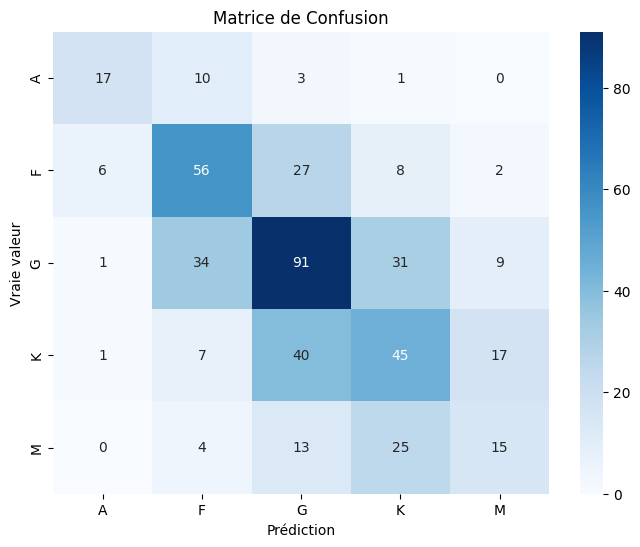

  > Modèle sauvegardé dans : c:\Users\alexb\Documents\Google_Cloud\alex_labs_google_sprint\astro_spectro_git\data\models\spectral_classifier_final.pkl

--- ÉTAPE 6: Mise à jour du Journal des Spectres Utilisés ---

  > 1850 nouveaux spectres ajoutés au journal 'c:\Users\alexb\Documents\Google_Cloud\alex_labs_google_sprint\astro_spectro_git\data\catalog\trained_spectra.csv'.

--- ÉTAPE 7: Génération du Rapport de Session ---
  > Hash MD5 du modèle : 3a2f029041d9a71b44271aeec67b6891
  > Métriques extraites : Accuracy = 0.48

Rapport de session sauvegardé dans : c:\Users\alexb\Documents\Google_Cloud\alex_labs_google_sprint\astro_spectro_git\data\reports\session_report_20250723T184701Z.json


SESSION DE RECHERCHE TERMINÉE


In [ ]:
import pandas as pd
from pipeline.classifier import SpectralClassifier
import os
import glob
import hashlib
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 1) Charger le dernier dataset de features
list_of_feature_files = glob.glob(os.path.join(PROCESSED_DIR, 'features_*.csv'))
if not list_of_feature_files:
    print("ERREUR : Aucun fichier de features trouvé.")
else:
    latest_feature_file = max(list_of_feature_files, key=os.path.getctime)
    print(f"--- Chargement du dataset : {os.path.basename(latest_feature_file)} ---")
    features_df = pd.read_csv(latest_feature_file)

    # 2) Créer la colonne 'label' et nettoyer les données
    if 'subclass' in features_df.columns:
        features_df['label'] = features_df['subclass'].astype(str).str[0]
    else:
        features_df['label'] = 'UNKNOWN'
        
    initial_count = len(features_df)
    df_trainable = features_df[features_df["label"].notnull() & ~features_df["label"].isin(['U', 'N', 'n', 'N'])].copy() # Ajout de 'N' majuscule
    print(f"  > {initial_count - len(df_trainable)} lignes avec des labels invalides ou nuls supprimées.")
    
    label_counts = df_trainable["label"].value_counts()
    rare_labels = label_counts[label_counts < 5].index
    if len(rare_labels) > 0:
        print(f"  > Suppression des classes trop rares : {list(rare_labels)}")
        df_trainable = df_trainable[~df_trainable["label"].isin(rare_labels)]

    # 3) Préparer X et y, puis lancer l'entraînement
    if not df_trainable.empty:
        feature_cols = [col for col in df_trainable.columns if col.startswith('feature_')]
        X = df_trainable[feature_cols].values
        y = df_trainable["label"].values

        print(f"\nFeatures utilisées : {feature_cols}")
        print(f"Nombre d'échantillons final : {X.shape[0]}, Nombre de features : {X.shape[1]}")

        print("\n--- ÉTAPE 5: Entraînement et Évaluation du modèle ---")
        clf = SpectralClassifier(n_estimators=200)
        clf.train_and_evaluate(X, y, test_size=0.25)
        
        # --- Si l'entraînement a réussi, on continue avec la sauvegarde et le rapport ---
        
        # 4) Sauvegarder le modèle
        model_path = os.path.join(MODELS_DIR, "spectral_classifier.pkl")
        os.makedirs(MODELS_DIR, exist_ok=True)
        clf.save_model(model_path)
        
        # 5) Mettre à jour le journal des spectres
        print("\n--- ÉTAPE 6: Mise à jour du Journal des Spectres Utilisés ---")
        processed_files = df_trainable['file_path'].tolist()
        builder.update_trained_log(processed_files)
        
        # 6) Générer le rapport de session
        print("\n--- ÉTAPE 7: Génération du Rapport de Session ---")
        timestamp = datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ")
        
        model_hash = "N/A"
        if os.path.exists(model_path):
            with open(model_path, "rb") as f:
                model_hash = hashlib.md5(f.read()).hexdigest()
            print(f"  > Hash MD5 du modèle : {model_hash}")
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
        predictions = clf.model.predict(X_test)
        report_dict = classification_report(y_test, predictions, labels=clf.class_labels, zero_division=0, output_dict=True)
        metrics_summary = report_dict.get("weighted avg", {})
        print(f"  > Métriques extraites : Accuracy = {report_dict.get('accuracy', 0):.2f}")

        session_report = {
            "session_id": timestamp,
            "date_utc": datetime.now(timezone.utc).isoformat(),
            "model_path": model_path,
            "model_hash_md5": model_hash,
            "training_set_size": len(X_train),
            "test_set_size": len(X_test),
            "total_spectra_processed": len(processed_files),
            "feature_columns": feature_cols,
            "class_labels": clf.class_labels,
            "metrics": metrics_summary,
            "processed_files_list": processed_files
        }

        report_filename = f"session_report_{timestamp}.json"
        report_path = os.path.join(REPORTS_DIR, report_filename)
        os.makedirs(REPORTS_DIR, exist_ok=True)

        with open(report_path, "w", encoding="utf-8") as f:
            json.dump(session_report, f, indent=4)
        print(f"\nRapport de session sauvegardé dans : {report_path}")
        
        print("\n\nSESSION DE RECHERCHE TERMINÉE")
    else:
        print("\n  > Pas assez de données valides pour lancer l'entraînement.")

#

## **Permettre l'affichage des labels**

In [ ]:
print(features_df["label"].value_counts())